# Generating the cluster number density

We will compute the cluster number density, $n(s, p)$, from sets of percolating two-dimensional clusters. As the cluster number density is not known analytically in all but the simplest systems, i.e., the infinite dimensional and the one-dimensional system, we will estimate it numerically. This is done by
\begin{align}
    n(s, p; L) \approx \frac{N_s}{ML^d},
\end{align}
where $s$ is the size of the cluster, $p$ the probability for a site to be set in the system, $L$ the length of a side in the system (assuming equal lengths for all sides), $d$ the dimension of the problem ($L^d$ is the volume), $N_s$ the number of clusters of size $s$ and $M$ the number of simulations performed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import skimage
import tqdm
import sklearn.linear_model
from uncertainties import ufloat

sns.set(color_codes=True)

In [2]:
def is_percolating(prop, num_rows, num_cols):
    min_row, min_col, max_row, max_col = prop.bbox

    return max_row - min_row == num_rows or max_col - min_col == num_cols

In [3]:
def compute_cluster_area(system, p, remove_percolating_cluster=True):
    mat = system < p
    # Label and count the number of connected clusters
    labels, num_features = scipy.ndimage.measurements.label(mat)
    s_list = skimage.measure.regionprops(labels)

    new_s_list = []
    if remove_percolating_cluster:
        for s in s_list:
            if is_percolating(s, *system.shape):
                continue
            new_s_list.append(s)
    else:
        new_s_list = s_list
            
    area = list(map(lambda prop: prop.area, new_s_list))

    return area

Example code to plot a specific prop in a system.

```python
box = s[1].bbox
plt.matshow(labels[box[0]:box[2], box[1]:box[3]], cmap="hsv")
plt.show()
```

In [4]:
def compute_cluster_number_density(L, M, p, a=1.2):
    area = []
    for i in range(M):
        z = np.random.rand(L, L)
        area.extend(compute_cluster_area(z, p))

    n, s = np.histogram(area, L ** 2)

    # Logarithmic binning
    logamax = np.ceil(np.log(max(s)) / np.log(a))
    bins = a ** np.arange(0, logamax, 1)

    nl, _ = np.histogram(area, bins)
    ds = np.diff(bins)
    sl = (bins[1:] + bins[:-1]) * 0.5
    nsl = nl / (M * L ** 2 * ds)

    # Remove bins where there are no observations
    mask = np.abs(nsl) > 1e-14

    return sl[mask], nsl[mask]

In [5]:
p_c = 0.59275

Below we plot the cluster number density as $p \to p_c = 0.59275$ from below.

Widget Javascript not detected.  It may not be installed or enabled properly.


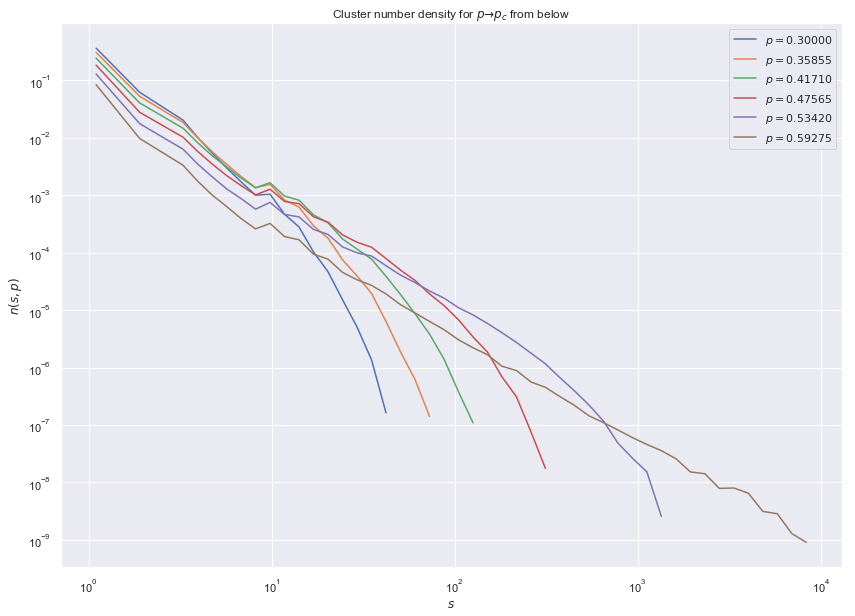

In [6]:
fig = plt.figure(figsize=(14, 10))

for p in tqdm.tqdm_notebook(np.linspace(0.3, p_c, 6)):
    plt.loglog(
        *compute_cluster_number_density(200, 200, p, a=1.2),
        label=rf"$p = {p:.5f}$"
    )

plt.legend(loc="best")
plt.title(r"Cluster number density for $p \to p_c$ from below")
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.show()

In this figure we can see how the cluster number density follows a seemingly straight line for a while, before dropping of sharply when $p$ is a little off from the critical percolation probability. This shows how the cluster number density at the critical percolation probability follows a power law as the axes are logarithmic.

Here we repeat the experiment, but for $p \to p_c$ from above.

Widget Javascript not detected.  It may not be installed or enabled properly.


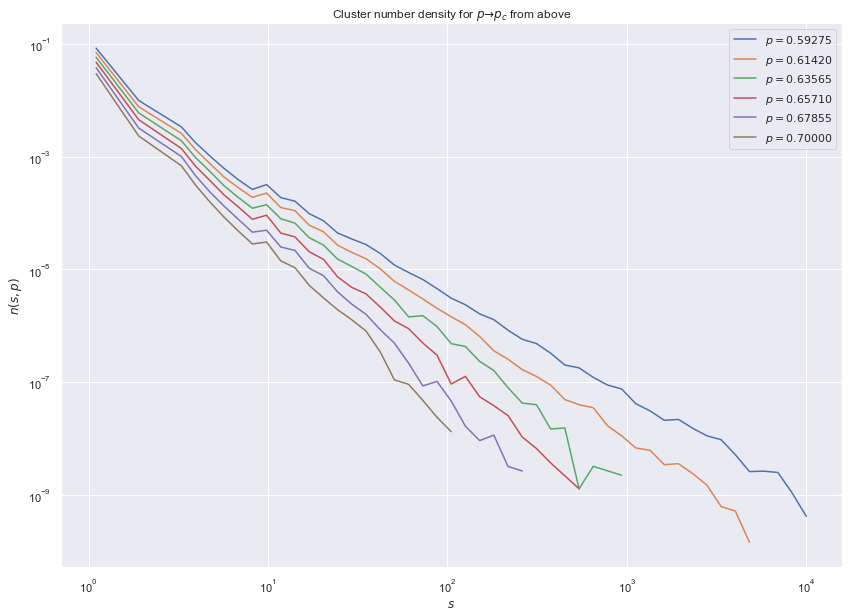

In [7]:
fig = plt.figure(figsize=(14, 10))

for p in tqdm.tqdm_notebook(np.linspace(p_c, 0.7, 6)):
    plt.loglog(
        *compute_cluster_number_density(200, 200, p, a=1.2),
        label=rf"$p = {p:.5f}$"
    )

plt.legend()
plt.title(r"Cluster number density for $p \to p_c$ from above")
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.show()

When $p \to p_c$ from above, we see that all cluster number densities behave in a power law fashion. Why is that?

## The cluster number density at the critical percolation probability

For $p = p_c = 0.59275$, we explore how the cluster number density changes for a system of $L = 2^k$ for $k = \{4, \dots, 9\}$.
We wish to show how the cluster number density deviates from the power law behavior, when $p = p_c$. We expect that
\begin{align}
    n(s, p_c; L) = F\left(\frac{s}{s_{\xi}}\right) s^{-\tau} \propto s^{-\tau},
\end{align}
where $F$ is some function that is constant when $p = p_c$.
By taking the logarithm on both sides, we get an expression for $\tau$.
\begin{gather}
    \log\left[n(s, p_c; L)\right]
    =
    -\tau \log\left[ s \right]
    + \log\left[ F\left(\frac{s}{s_{\xi}}\right) \right].
\end{gather}
We use linear regression to get an estimate for $-\tau$. We also compute $-\tau$ manually by computing the decrease between two values of $s$, for all differences. We find our best estimate by computing the mean of $-\tau$.

In [8]:
L_arr = 2 ** np.arange(4, 10)
true_tau = 187 / 91

Widget Javascript not detected.  It may not be installed or enabled properly.


For L = 16: -tau = -1.8567	C = -16.1469
For L = 32: -tau = -1.9087	C = -17.4772
For L = 64: -tau = -1.8694	C = -19.1704
For L = 128: -tau = -1.8588	C = -20.5506
For L = 256: -tau = -1.8799	C = -21.0091
For L = 512: -tau = -1.9008	C = -21.2238



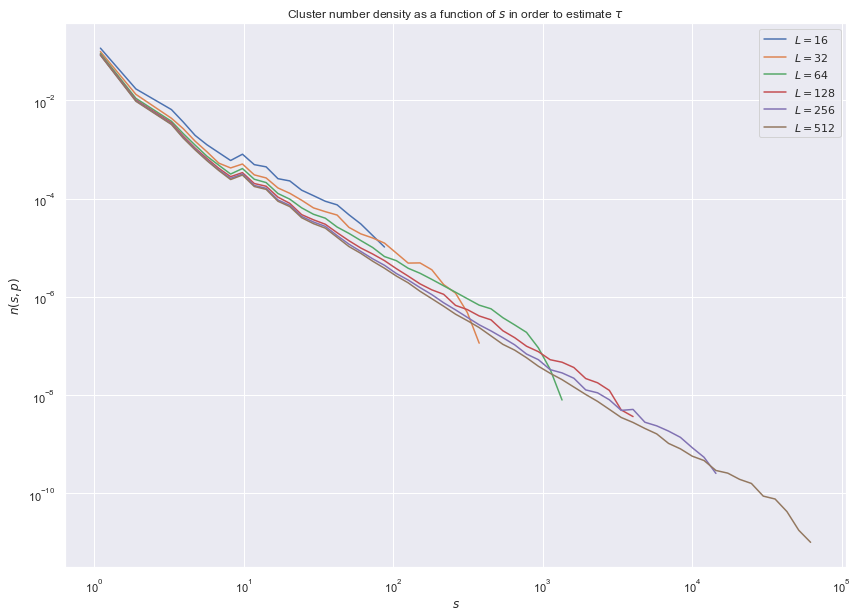

In [9]:
fig = plt.figure(figsize=(14, 10))
a = 1.2
tau_list = []

for L in tqdm.tqdm_notebook(L_arr):
    sl, nsl = compute_cluster_number_density(L, 500, p=p_c, a=a)

    log_sl = np.log(sl) / np.log(a)
    log_nsl = np.log(nsl) / np.log(a)
    
    plt.loglog(sl, nsl, label=rf"$L = {L}$")
    clf = sklearn.linear_model.LinearRegression(
        fit_intercept=True
    ).fit(log_sl[:, None], log_nsl[:, None])

    tau = clf.coef_[0, 0]
    C = clf.intercept_[0]

    print(f"For L = {L}: -tau = {tau:.4f}\tC = {C:.4f}")

    tau_arr = np.zeros(int(len(log_nsl) * (len(log_nsl) - 1) / 2))
    index = 0
    for i in range(len(log_nsl)):
        for j in range(i + 1, len(log_nsl)):
            tau = (log_nsl[j] - log_nsl[i]) / (log_sl[j] - log_sl[i])
            tau_arr[index] = tau
            index += 1

    tau_list.append(tau_arr.copy())

plt.title(r"Cluster number density as a function of $s$ in order to estimate $\tau$")
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.show()

Below we display the mean value for $-\tau$ with its standard deviation for each size $L$.

In [10]:
for L, tau in zip(L_arr, tau_list):
    print(f"For L = {L}: tau = {np.mean(tau):.2f} +/- {np.std(tau):.2f}")

For L = 16: tau = -1.83 +/- 0.57
For L = 32: tau = -1.93 +/- 0.68
For L = 64: tau = -1.89 +/- 0.58
For L = 128: tau = -1.86 +/- 0.33
For L = 256: tau = -1.88 +/- 0.28
For L = 512: tau = -1.90 +/- 0.27


We see that this is quite far off from the true value $-\tau = 187 / 91 \approx 2.05$. Below we output the error in $-\tau$.

In [11]:
unc_tau = [ufloat(np.mean(tau), np.std(tau)) for tau in tau_list]

for L, tau in zip(L_arr, unc_tau):
    print(f"For L = {L}: error tau = {true_tau + tau}")

For L = 16: error tau = 0.2+/-0.6
For L = 32: error tau = 0.1+/-0.7
For L = 64: error tau = 0.2+/-0.6
For L = 128: error tau = 0.20+/-0.33
For L = 256: error tau = 0.18+/-0.28
For L = 512: error tau = 0.15+/-0.27


We can see that our estimate for $-\tau$ is quite far off. This indicates that using linear regression on the slope of the logarithmically binned cluster number density against the cluster size is not very precise.

## Measuring the characteristic cluster size $s_\xi$

The scaling of the characteristic cluster size $s_{\xi}$ is given by
\begin{align}
    s_{\xi} \propto |p - p_c|^{-1 / \sigma}.
\end{align}
We _define_ the characteristic cluster size by the point where
\begin{gather}
    \frac{n(s, p)}{n(s, p_c)} = F\left(\frac{s}{s_{\xi}}\right) = \frac{1}{2},
    \\
    \implies
    n(s, p) = \frac{1}{2} n(s, p_c).
\end{gather}
The equality is hard to match exactly, so numerically we define it to be
\begin{align}
    n(s, p) \leq \frac{1}{2} n(s, p_c).
\end{align}
The value of $s$ that first satisfies this equation is then our estimate of the characteristic cluster size $s_{\xi}$. We look at the characteristic cluster size for $p \to p_c$ from below.

In [12]:
L = 512
M = 500
p_list = [0.45, 0.5, 0.54, 0.57, 0.58] # Numbers from book

Widget Javascript not detected.  It may not be installed or enabled properly.


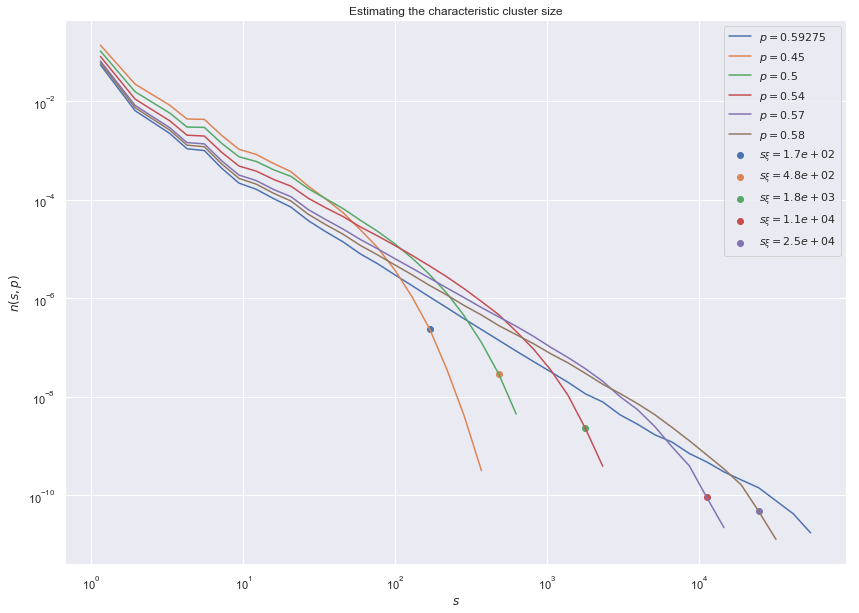

In [13]:
fig = plt.figure(figsize=(14, 10))
a = 1.3
s_xi_list = []
sl_list = []
nsl_list = []

sl_c, nsl_c = compute_cluster_number_density(L, M, p=p_c, a=a)
plt.loglog(sl_c, nsl_c, label=rf"$p = {p_c}$")

for p in tqdm.tqdm_notebook(p_list):
    sl, nsl = compute_cluster_number_density(L, M, p=p, a=a)
    sl_list.append(sl)
    nsl_list.append(nsl)

    plt.loglog(sl, nsl, label=rf"$p = {p}$")

    mask = nsl <= 0.5 * nsl_c[:len(nsl)]

    # If no points are below the cluster number density at p = p_c,
    # skip that index.
    if not np.any(mask):
        continue

    index = np.argmax(mask)

    s_xi = sl[index]
    s_xi_list.append(s_xi)

    plt.scatter(s_xi, nsl[index], label=(r"$s_\xi = {0:.2}$").format(s_xi))


plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$n(s, p)$")
plt.title(r"Estimating the characteristic cluster size")
plt.show()

In this plot we have marked the characteristic cluster size $s_{\xi}$ by dots. We now plot these as a function of the percolation probability $p$.

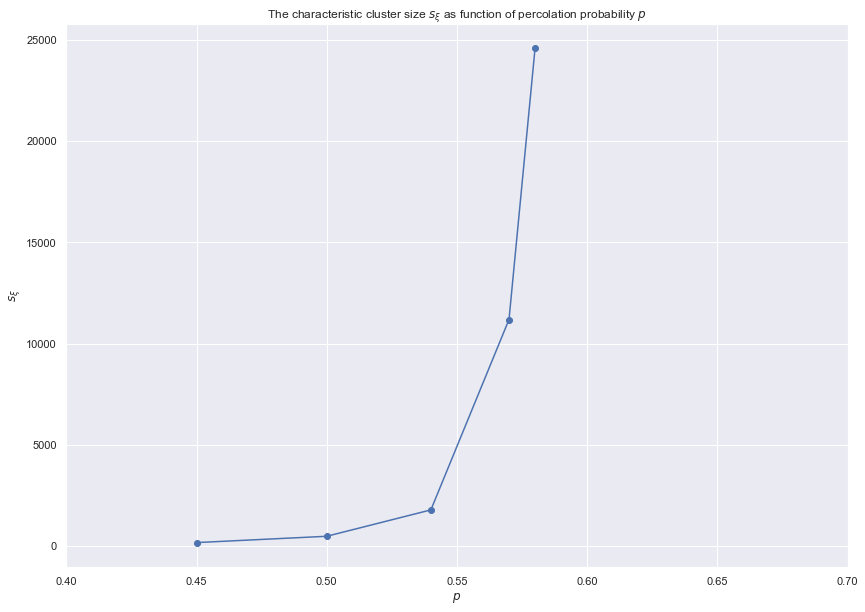

In [14]:
fig = plt.figure(figsize=(14, 10))

plt.plot(p_list, s_xi_list, "-o")
plt.xlim(0.4, 0.7)
plt.title(r"The characteristic cluster size $s_{\xi}$ as function of percolation probability $p$")
plt.xlabel(r"$p$")
plt.ylabel(r"$s_{\xi}$")
plt.show()

In this figure we see how the characteristic cluster size $s_{\xi}$ diverges as $p \to p_c$ from below, that is, the cluster number density follows the power law type behaviour for longer before dropping off towards zero. For the scaling
\begin{align}
    s_{\xi} = C|p - p_c|^{-1 / \sigma},
\end{align}
where $C$ is a constant, we can find an expression for the exponent $\sigma$ by taking the logarithm on both sides and rearranging the terms.
\begin{gather}
    \log(s_{\xi}) = \log(C) - \frac{1}{\sigma}\log\left(|p - p_c|\right).
\end{gather}
We use linear regression to find an expression for the coefficient $-\sigma^{-1}$.

In [15]:
s_xi_arr = np.log(np.array(s_xi_list))
p_min_pc = np.log(np.abs(p_c - np.array(p_list)))

In [16]:
clf = sklearn.linear_model.LinearRegression().fit(
    p_min_pc[:, None], s_xi_arr[:, None]
)

coef = clf.coef_[0, 0]
sigma = - 1 / coef

print(f"sigma = {sigma}")

sigma = 0.47692140021677076


The true value for $\sigma$ in $d = 2$ dimensions is
\begin{align}
    \sigma = \frac{36}{91} \approx 0.395.
\end{align}
The absolute difference between this value and the one found by us is computed below.

In [17]:
sigma_true = 36 / 91

print(f"Diff in sigma: {np.abs(sigma_true - sigma)}")

Diff in sigma: 0.08131700461237518


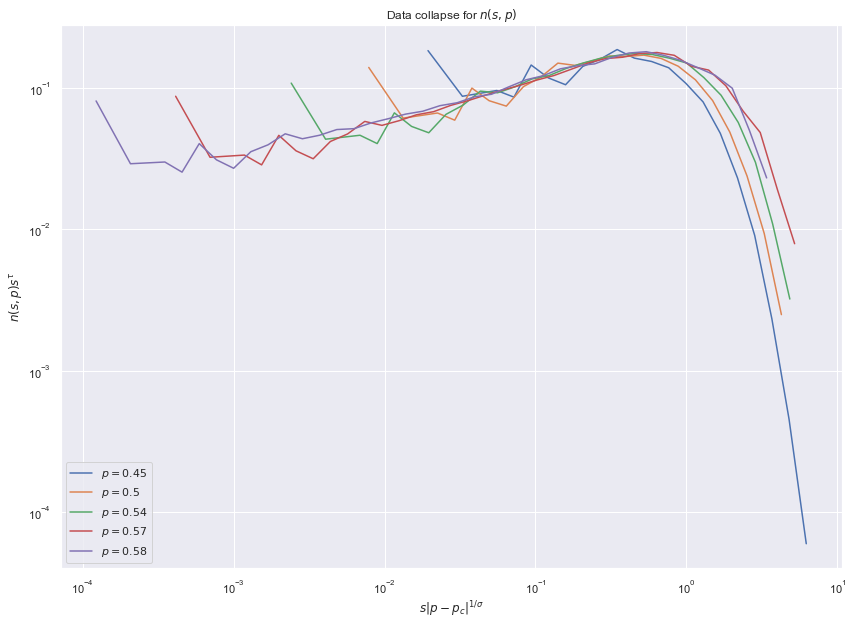

In [33]:
fig = plt.figure(figsize=(14, 10))

for i, p in enumerate(p_list):
    y_vals = nsl_list[i] * sl_list[i] ** true_tau
    x_vals = sl_list[i] * np.abs(p - p_c) ** (1 / sigma)

    plt.loglog(x_vals, y_vals, label=fr"$p={p}$")

plt.legend(loc="best")
plt.title(r"Data collapse for $n(s, p)$")
plt.xlabel(r"$s |p - p_c|^{1/\sigma}$")
plt.ylabel(r"$n(s, p) s^{\tau}$")
plt.show()

In this figure we can see the data collapse of the cluster number density.

## Mass scaling of percolation cluster

We now compute the mass of the percolating cluster $M(L)$ at $p = p_c$.
When $p = p_c$ the characteristic length, $\xi \to \infty$.
This means that the mass scales as
\begin{align}
    M(L) \propto L^{D}.
\end{align}
Taking the logarithm on both sides, we can find an estimate for $D$ using linear regression, viz.
\begin{align}
    \log\left(M(L)\right)
    = \log(C) + D\log(L),
\end{align}
where $C$ is a constant.
We compute the mass of the percolating cluster by counting the number of set sites contained in the cluster that spans the entire system length $L$.

In [19]:
def compute_mass_of_percolating_cluster(system):
    L = system.shape[0]

    # Label and count the number of connected clusters
    labels, num_features = scipy.ndimage.measurements.label(system)
    s_list = skimage.measure.regionprops(labels)
    
    for s in s_list:
        if is_percolating(s, *system.shape):
            # We look at the first percolating cluster that we find.
            # There might be more than one, but we ignore these.
            return s.area

    return 0

In [20]:
L_arr = 2 ** np.arange(4, 11)
mass_arr = np.zeros(len(L_arr))
M = 100

We repeat the experiment $M$ times to make sure that we actually get a percolating cluster for all system sizes.

In [21]:
for i, L in tqdm.tqdm_notebook(enumerate(L_arr)):
    for _ in range(M):
        system = np.random.rand(L, L) <= p_c
        mass_arr[i] += compute_mass_of_percolating_cluster(system)

mass_arr /= M

Widget Javascript not detected.  It may not be installed or enabled properly.


Fitting the data to find $D$ and the intercept $C$.

In [22]:
clf = sklearn.linear_model.LinearRegression().fit(
    np.log(L_arr)[:, None],
    np.log(mass_arr)[:, None]
)

D = clf.coef_[0, 0]
print(f"D = {D}")

D = 1.895808803079029


The true value of $D$ is given by
\begin{align}
    D = \frac{91}{48} \approx 1.896.
\end{align}
Thus, the absolute difference between the true value and our estimated value is given by.

In [23]:
D_true = 91 / 48

print(f"Diff: {np.abs(D_true - D)}")

Diff: 2.453025430426692e-05


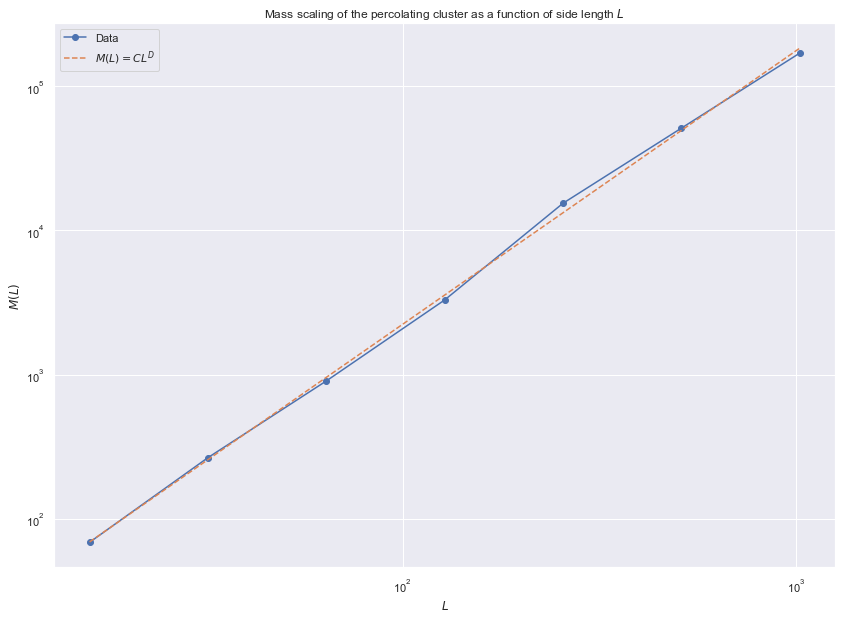

In [24]:
fig = plt.figure(figsize=(14, 10))

plt.loglog(L_arr, mass_arr, "-o", label=r"Data")
plt.loglog(
    L_arr,
    np.exp(clf.intercept_[0]) * L_arr ** D,
    "--",
    label=r"$M(L) = C L^{D}$"
)

plt.title(r"Mass scaling of the percolating cluster as a function of side length $L$")
plt.xlabel(r"$L$")
plt.ylabel(r"$M(L)$")
plt.legend()
plt.show()

In this figure we can see how the log-log plot of the mass and the system size follows a power law type behaviour. We have also plotted the theoretical line on top using our estimate for $D$.